In [1]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (17.0, 77.0)

import pylab
from tsne import bh_sne
from matplotlib import pyplot as plt
import pandas
import scipy
import numpy as np
import sklearn.manifold
import os
import gc
from time import gmtime, strftime
import seaborn as sns
from os import listdir
from os.path import isfile, join
import math
from scipy.stats.stats import pearsonr
import random as rand
import pyproj


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
def load_data(path):
    gc.collect()
    labels = list(pandas.read_hdf(path, '/df').columns.values)#.get('accrued_depr_pct')
    data = pandas.read_hdf(path, '/df')
    return data
def display_heightmap(mat):
    mat = mat.copy()
    mat[mat<-1000] = -100
    plt.imshow((mat), interpolation='nearest')
#     print(mat)
    plt.show()


In [3]:
meta = load_data("/home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad200_hist8x8.mat.hd")

Opening /home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad200_hist8x8.mat.hd in read-only mode
Opening /home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad200_hist8x8.mat.hd in read-only mode


In [141]:


wgs84=pyproj.Proj("+init=EPSG:4326") # LatLon with WGS84 datum used by GPS units and Google Earth
UTM26N=pyproj.Proj("+init=EPSG:2278") # UTM coords, zone Texas Central, WGS84 datum

def feet_to_lon_lat(x,y):
    x = [x*.3048] # convert to meters
    y = [y*.3048]
    return pyproj.transform(UTM26N, wgs84, x, y)



In [4]:
from os import listdir
from os.path import isfile, join

file_attributes = {}

mypath = "/home/isaac/Desktop/devika/ARCGIS/ArcGis/ascii_files"
for filename in [f for f in listdir(mypath) if isfile(join(mypath, f))]: 
    attributes = {}
    with open(mypath + "/" + filename) as FileObj:
        for index, line in enumerate(FileObj):
            if(index < 6):
#                 print line
                attributes[line.split(" ")[0]] = int(line.split(" ")[-1][:-2])
            else:
                break # don't load the other lines into memory becuase that's a waste of time.

#     pickle_path = "/home/isaac/Desktop/devika/ARCGIS/ArcGis/pickle_files/" + filename + ".npy"
#     f = file(pickle_path,"wb")
#     mat = np.loadtxt(mypath + "/" + filename, dtype='float16', comments='#', delimiter=" ", converters=None, skiprows=6, usecols=range(0,attributes['ncols']), unpack=False, ndmin=0)
#     np.save(f, mat)
#     f.close()
    attributes['width'] = attributes['ncols'] * attributes['cellsize']
    attributes['height'] = attributes['nrows'] * attributes['cellsize']
    file_attributes[filename] = attributes
print "loaded all file header attributes into dict"

loaded all file header attributes into dict


In [5]:
def get_file_containing(housex, housey):
        print "house coords:", housex, housey
        for key in file_attributes:
            block = file_attributes[key]
    #         print block['xllcorner'], block['yllcorner']
            if block['xllcorner'] < housex < block['xllcorner'] + block['width']:
                if block['yllcorner'] < housey < block['yllcorner'] + block['height']:
                    return key


#housex and housey in meters
def get_heightmap_around(housex, housey, window_width_feet = 200, window_width_pixels = 300):
    housex /= .3048 #convert to feet
    housey /= .3048  
    x=housex
    y=housey

    key = get_file_containing(x,y)
    block = file_attributes[key]
    print "found map:", key, block['xllcorner'], block['yllcorner'], block['width'], block['height']

    f = file("/home/isaac/Desktop/devika/ARCGIS/ArcGis/pickle_files/"+key+".npy","rb")
    mat = np.load(f)
    imagex = (int(x)-block['xllcorner'])/5
    imagey = (int(y)-block['yllcorner'])/5
#                 print imagex, imagey

    x1 = np.max([0,              imagex - window_width_pixels/2])
    x2 = np.min([block['ncols'], imagex+window_width_pixels/2])

    y1 = np.max([0,              imagey - window_width_pixels/2])
    y2 = np.min([block['nrows'], imagey+window_width_pixels/2])

#     display_heightmap(mat)
    print "min max", np.min(mat), np.max(mat)
    display_heightmap(np.log(mat[block['nrows']-y2:block['nrows']-y1,
                          x1:x2]))

def window_violated_chunk_borders(housex, housey):
    corners = [(housex-window_width_feet/2, housey-window_width_feet/2),
              (housex-window_width_feet/2, housey+window_width_feet/2),
              (housex+window_width_feet/2, housey+window_width_feet/2),
              (housex+window_width_feet/2, housey-window_width_feet/2)]
    files = map(lambda x: get_file_containing(x[0], x[1]), corners)
    return len(set(files)) > 1

house lat lon [29.7474450506] [-95.408154660600005]
[947344.8134618559] [4217470.113760866]
house coords: 3108086.65834 13836844.2053
found map: rastert_dsm_q243.txt 3098665 13814815 20550 23345
min max -25.031 564.0


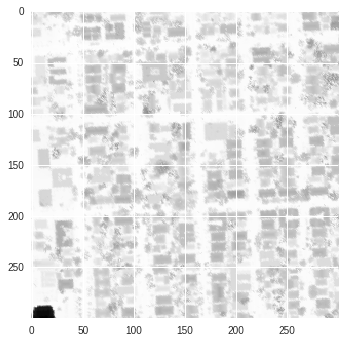

In [6]:
wgs84=pyproj.Proj("+init=EPSG:4326") # LatLon with WGS84 datum used by GPS units and Google Earth
UTM26N=pyproj.Proj("+init=EPSG:2278") # UTM coords, zone Texas Central, WGS84 datum

# lon = [meta['lon'][250000]] #these are good becuase of clear local features
# lat = [meta['lat'][250000]]


lon = [meta['lon'][12000]]
lat = [meta['lat'][12000]]

print "house lat lon", lat, lon
xx, yy = pyproj.transform(wgs84, UTM26N, lon, lat)
print xx, yy
housex=xx[0]
housey=yy[0]
get_heightmap_around(housex,housey)

In [7]:
plt.imshow(mat[:,:])
plt.show()

TypeError: 'function' object has no attribute '__getitem__'

In [ ]:
f = file("tmp.np","wb")
np.save(f, mat)

You can compare the image displayed here with google maps to convince yourself that this is the correct map in the right orientation

In [11]:
f = file("/home/isaac/Desktop/devika/ARCGIS/ArcGis/pickle_files/rastert_dsm_q116.txt.npy","rb")
matloaded = np.load(f)
with open("/home/isaac/Desktop/devika/ARCGIS/ArcGis/ascii_files/rastert_dsm_q116.txt") as myfile:
    head = "".join([next(myfile) for x in xrange(6)])
print head

print feet_to_lon_lat(2957465, 13901720)
display_heightmap(matloaded)

ncols         4084
nrows         4655
xllcorner     2957465
yllcorner     13901720
cellsize      5
NODATA_value  -9999



NameError: name 'feet_to_lon_lat' is not defined

In [12]:
f = file("/home/isaac/Desktop/devika/ARCGIS/ArcGis/pickle_files/rastert_dsm_q247.txt.npy","rb")
matloaded = np.load(f)
with open("/home/isaac/Desktop/devika/ARCGIS/ArcGis/ascii_files/rastert_dsm_q247.txt") as myfile:
    head = "".join([next(myfile) for x in xrange(6)])
print head

print feet_to_lon_lat(3059015+4105*5, 13813630+4665*5)
display_heightmap(matloaded[:500,4105-500:].clip(-100,100))

ncols         4105
nrows         4665
xllcorner     3059015
yllcorner     13813630
cellsize      5
NODATA_value  -9999



NameError: name 'feet_to_lon_lat' is not defined